# Deep Neural Network

## 1. Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.utils import shuffle


## 2. Import and pre-process data

In [2]:
data = pd.read_csv('./Data/onlinefraud.csv')
# Convert the 'type' attribute to a numerical one
data["type"] = data["type"].map({"CASH_OUT": 1, "PAYMENT": 2, "CASH_IN": 3, "TRANSFER": 4, "DEBIT": 5})
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,2,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,2,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,4,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,1,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,2,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [3]:
data = data.drop(["nameOrig", "nameDest"], axis=1)

In [4]:
# Shuffle the data randomly
data = data.sample(frac=1, random_state=42)

# Set the target variable (y) and input features (X)
target_variable = 'isFraud'
input_features = [col for col in data.columns if col != target_variable]

# Determine the proportions for train, test, and validation sets
train_ratio = 0.8
test_ratio = 0.1
validation_ratio = 0.1

# Split the data into train, test, and validation sets
train_data, remaining_data = train_test_split(data, test_size=1 - train_ratio, random_state=42)
test_data, validation_data = train_test_split(remaining_data, test_size=validation_ratio / (test_ratio + validation_ratio), random_state=42)

# Set the y and X values for train, test, and validation sets
y_train = train_data[target_variable]
X_train = train_data[input_features]

y_test = test_data[target_variable]
X_test = test_data[input_features]

y_validation = validation_data[target_variable]
X_validation = validation_data[input_features]

# Scale the input features
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_validation_scaled = scaler.transform(X_validation)

# Verify the shapes of the resulting sets
print("Train set shapes - X:", X_train_scaled.shape, "y:", y_train.shape)
print("Test set shapes - X:", X_test_scaled.shape, "y:", y_test.shape)
print("Validation set shapes - X:", X_validation_scaled.shape, "y:", y_validation.shape)

Train set shapes - X: (5090096, 8) y: (5090096,)
Test set shapes - X: (636262, 8) y: (636262,)
Validation set shapes - X: (636262, 8) y: (636262,)


## 3. Helper Function

In [31]:
# Function to train a DNN and return the metrics
def train_dnn(X_train, y_train, X_val, y_val, X_test, y_test, epochs, batch_size):
    model = Sequential()
    model.add(Dense(15, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(24, activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(20, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy',metrics=['Precision','Recall'])

    # Train the model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)
    
    # Make predictions on trained data for stats on model
    y_tra_pred = model.predict(X_train)
    y_tra_pred = np.round(y_tra_pred)

    # Make predictions on validation data
    y_val_pred = model.predict(X_val)
    y_val_pred = np.round(y_val_pred)
    
    # Make predictions on test data
    y_test_pred = model.predict(X_test)
    y_test_pred = np.round(y_test_pred)
    
    # Calculate metrics for training data
    tra_cm = confusion_matrix(y_train, y_tra_pred)
    tra_f1 = f1_score(y_train, y_tra_pred)
    tra_precision = precision_score(y_train, y_tra_pred)
    tra_recall = recall_score(y_train, y_tra_pred)
    tra_accuracy = accuracy_score(y_train, y_tra_pred)

    # Calculate metrics for validation data
    val_cm = confusion_matrix(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Calculate metrics for test data
    test_cm = confusion_matrix(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    loss = history.history['loss']
    weight_matrix = model.get_weights()

    return (tra_cm, tra_f1, tra_precision, tra_recall, tra_accuracy,val_cm, val_f1, val_precision, val_recall, val_accuracy,
            test_cm, test_f1, test_precision, test_recall, test_accuracy,
            loss, weight_matrix)

In [6]:
# Display Confusion Matrix
def display_confusion_matrix(confusion_matrix):
    labels = ['Not Fraud', 'Fraud']
    confusion_matrix_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=labels)

    confusion_matrix_display.plot()

    plt.title('Deep Neural Network Confusion Matrix:')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.figure(figsize=(5,5))

    plt.show()

## 4. Models

### 4A. Testing to find the best number of epochs on normal data

In [37]:
# Specify hyperparameters
epochs = [1,2,5,8,10]  # Number of epochs to train

batch_size = 32  # Batch size for training

# Initialize variables to store results
loss_per_epoch = []
val_metrics = []
test_metrics = []
train_accuracy_scores = []
test_accuracy_scores = []
validation_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
validation_precision_scores = []
train_recall_scores = []
test_recall_scores = []
validation_recall_scores = []
train_f1_scores = []
test_f1_scores = []
validation_f1_scores = []

# Iterate over different numbers of hidden layers
for epoch in epochs:
    # Train the DNN and obtain metrics
    tra_cm, tra_f1, tra_precision, tra_recall, tra_accuracy,val_cm, val_f1, val_precision, val_recall, val_accuracy, \
    test_cm, test_f1, test_precision, test_recall, test_accuracy, \
    loss, weight_matrix = train_dnn(X_train_scaled, y_train, X_validation_scaled, y_validation, X_test_scaled, y_test, epoch, batch_size)
    # Store the loss per epoch
    loss_per_epoch.append(loss)

    # Store the metrics
    val_metrics.append((val_cm, val_f1, val_precision, val_recall, val_accuracy))
    test_metrics.append((test_cm, test_f1, test_precision, test_recall, test_accuracy))
    train_accuracy_scores.append(tra_accuracy)
    test_accuracy_scores.append(test_accuracy)
    validation_accuracy_scores.append(val_accuracy)
    train_precision_scores.append(tra_precision)
    test_precision_scores.append(test_precision)
    validation_precision_scores.append(val_precision)
    train_recall_scores.append(tra_recall)
    test_recall_scores.append(test_recall)
    validation_recall_scores.append(val_recall)
    train_f1_scores.append(tra_f1)
    test_f1_scores.append(test_f1)
    validation_f1_scores.append(val_f1)
    
    


19884/19884 [==============================] - 13s 653us/step
Epoch 1/2
159066/159066 [==============================] - 193s 1ms/step - loss: 0.0059 - precision: 0.8629 - recall: 0.4517 - val_loss: 0.0055 - val_precision: 0.9912 - val_recall: 0.4070
Epoch 2/2
19884/19884 [==============================] - 11s 563us/step
Epoch 1/5
159066/159066 [==============================] - 194s 1ms/step - loss: 0.0052 - precision: 0.7713 - recall: 0.4812 - val_loss: 0.0052 - val_precision: 0.9805 - val_recall: 0.4838
Epoch 2/5
159066/159066 [==============================] - 201s 1ms/step - loss: 0.0055 - precision: 0.8900 - recall: 0.5583 - val_loss: 0.0052 - val_precision: 0.9933 - val_recall: 0.3577
Epoch 3/5
159066/159066 [==============================] - 191s 1ms/step - loss: 0.0060 - precision: 0.8633 - recall: 0.5418 - val_loss: 0.0072 - val_precision: 0.9931 - val_recall: 0.3457
Epoch 4/5
159066/159066 [==============================] - 188s 1ms/step - loss: 0.0073 - precision: 0.8850 - 

Metrics for 1 epochs:
Validation Metrics:
Confusion Matrix:
[[635423      6]
 [   427    406]]
F1-score: 0.6522088353413654
Precision: 0.9854368932038835
Recall: 0.48739495798319327
Accuracy: 0.9993194627370485

Test Metrics:
Confusion Matrix:
[[635412      8]
 [   452    390]]
F1-score: 0.6290322580645161
Precision: 0.9798994974874372
Recall: 0.46318289786223277
Accuracy: 0.9992770273880885



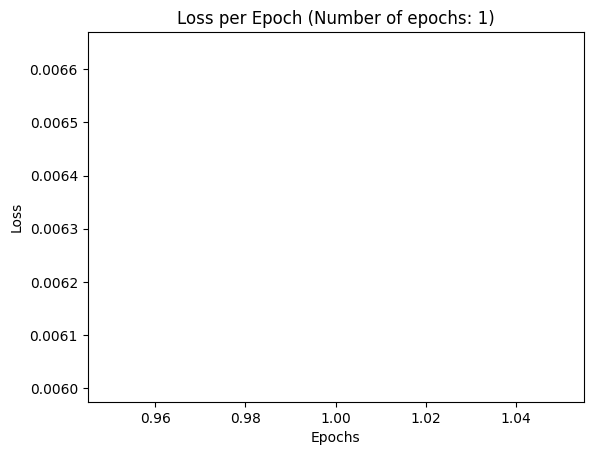

Metrics for 2 epochs:
Validation Metrics:
Confusion Matrix:
[[635429      0]
 [   517    316]]
F1-score: 0.5500435161009574
Precision: 1.0
Recall: 0.3793517406962785
Accuracy: 0.9991874416513952

Test Metrics:
Confusion Matrix:
[[635419      1]
 [   542    300]]
F1-score: 0.5249343832020998
Precision: 0.9966777408637874
Recall: 0.35629453681710216
Accuracy: 0.9991465779820262



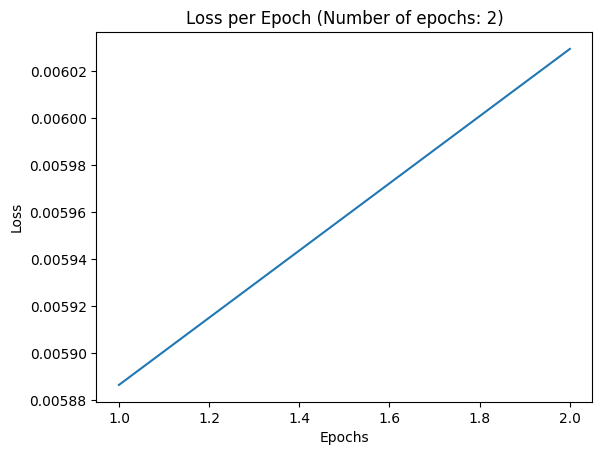

Metrics for 5 epochs:
Validation Metrics:
Confusion Matrix:
[[635427      2]
 [   481    352]]
F1-score: 0.5930918281381634
Precision: 0.9943502824858758
Recall: 0.4225690276110444
Accuracy: 0.999240878757493

Test Metrics:
Confusion Matrix:
[[635419      1]
 [   495    347]]
F1-score: 0.5831932773109243
Precision: 0.9971264367816092
Recall: 0.41211401425178146
Accuracy: 0.9992204469228085



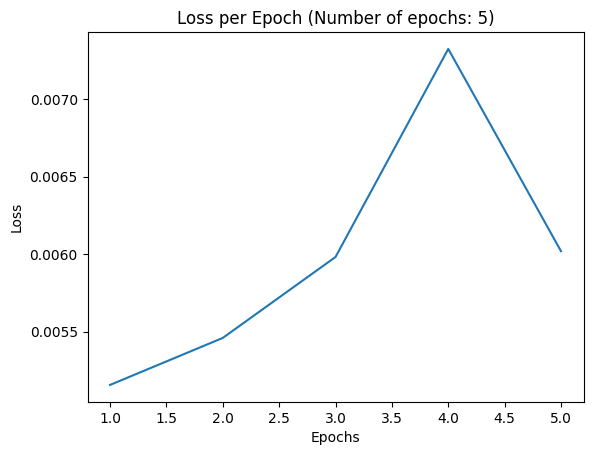

Metrics for 8 epochs:
Validation Metrics:
Confusion Matrix:
[[635428      1]
 [   562    271]]
F1-score: 0.4904977375565612
Precision: 0.9963235294117647
Recall: 0.32533013205282113
Accuracy: 0.999115144390204

Test Metrics:
Confusion Matrix:
[[635420      0]
 [   577    265]]
F1-score: 0.47877145438121044
Precision: 1.0
Recall: 0.3147268408551069
Accuracy: 0.9990931408759285



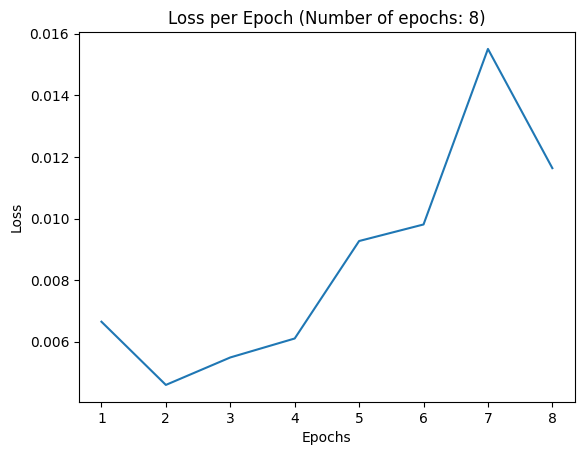

Metrics for 10 epochs:
Validation Metrics:
Confusion Matrix:
[[635428      1]
 [   566    267]]
F1-score: 0.48501362397820164
Precision: 0.996268656716418
Recall: 0.3205282112845138
Accuracy: 0.9991088576718395

Test Metrics:
Confusion Matrix:
[[635420      0]
 [   587    255]]
F1-score: 0.46490428441203285
Precision: 1.0
Recall: 0.3028503562945368
Accuracy: 0.9990774240800173



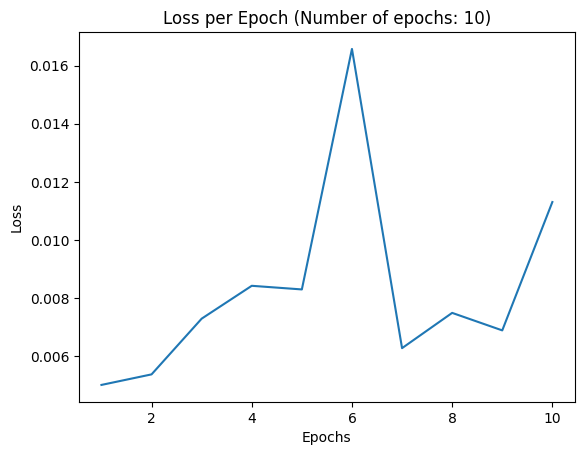

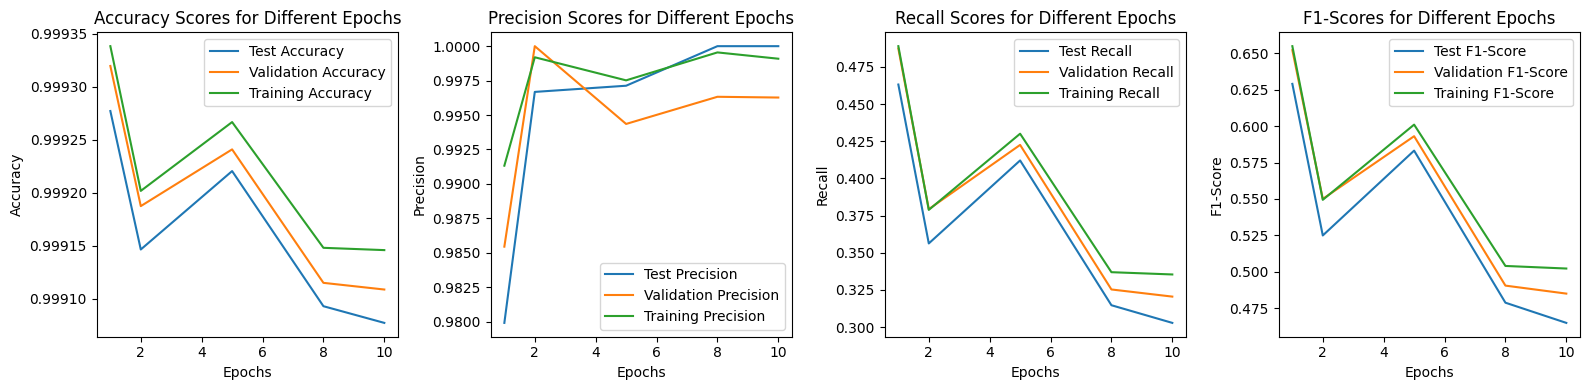

In [39]:
# Print and plot the metrics
for i, epoch in enumerate(epochs):
    print(f"Metrics for {epoch} epochs:")
    print("Validation Metrics:")
    val_cm, val_f1, val_precision, val_recall, val_accuracy = val_metrics[i]
    print("Confusion Matrix:")
    print(val_cm)
    print("F1-score:", val_f1)
    print("Precision:", val_precision)
    print("Recall:", val_recall)
    print("Accuracy:", val_accuracy)
    print()

    print("Test Metrics:")
    test_cm, test_f1, test_precision, test_recall, test_accuracy = test_metrics[i]
    print("Confusion Matrix:")
    print(test_cm)
    print("F1-score:", test_f1)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("Accuracy:", test_accuracy)
    print()
    
    plt.plot(range(1, epoch + 1), loss_per_epoch[i])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch (Number of epochs: {epoch})')
    plt.show()
# Create subplots with a row layout
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot accuracy scores

axs[0].plot(epochs, test_accuracy_scores, label='Test Accuracy')
axs[0].plot(epochs, validation_accuracy_scores, label='Validation Accuracy')
axs[0].plot(epochs, train_accuracy_scores, label='Training Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Scores for Different Epochs')
axs[0].legend()

# Plot precision scores

axs[1].plot(epochs, test_precision_scores, label='Test Precision')
axs[1].plot(epochs, validation_precision_scores, label='Validation Precision')
axs[1].plot(epochs, train_precision_scores, label='Training Precision')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision Scores for Different Epochs')
axs[1].legend()

# Plot recall scores

axs[2].plot(epochs, test_recall_scores, label='Test Recall')
axs[2].plot(epochs, validation_recall_scores, label='Validation Recall')
axs[2].plot(epochs, train_recall_scores, label='Training Recall')
axs[2].set_xlabel('Epochs')
axs[2].set_ylabel('Recall')
axs[2].set_title('Recall Scores for Different Epochs')
axs[2].legend()

# Plot F1 scores

axs[3].plot(epochs, test_f1_scores, label='Test F1-Score')
axs[3].plot(epochs, validation_f1_scores, label='Validation F1-Score')
axs[3].plot(epochs, train_f1_scores, label='Training F1-Score')
axs[3].set_xlabel('Epochs')
axs[3].set_ylabel('F1-Score')
axs[3].set_title('F1-Scores for Different Epochs')
axs[3].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()
    


#### Interpretation of the above data

On the normal set of data, applying more epochs increased the precision and decreased the recall value. We think this may be due to the number of actual fraudulent transactions in the set being too low and the model being trained to better identify "not fraud" than "fraud". To better this result, we should resample the data and introduce more "fraud" test cases which made lead to a lower precision. To counteract the expected drop in precision, we need to choose the most accurate epoch number. We have decided that 10 is the most precise and will be used for more testing and training

### 4B. Model using the most precise epoch with different sampling ratios

In [64]:
# Specify hyperparameters
epochs = 10  # Number of epochs to train
batch_size = 32  # Batch size for training
sampling_ratios = [0.5,0.1, 0.2, 0.3, 0.4]  # Sampling ratios to test

# Initialize variables to store results
loss_per_epoch = []
val_metrics = []
test_metrics = []
test_metrics = []
train_accuracy_scores = []
test_accuracy_scores = []
validation_accuracy_scores = []
train_precision_scores = []
test_precision_scores = []
validation_precision_scores = []
train_recall_scores = []
test_recall_scores = []
validation_recall_scores = []
train_f1_scores = []
test_f1_scores = []
validation_f1_scores = []

# Iterate over different sampling ratios
for ratio in sampling_ratios:
    # Apply SMOTE to augment the training data
    smote = SMOTE(sampling_strategy=ratio, random_state=42)
    X_train_aug, y_train_aug = smote.fit_resample(X_train_scaled, y_train)

    # Train the DNN and obtain metrics
    tra_cm, tra_f1, tra_precision, tra_recall, tra_accuracy,val_cm, val_f1, val_precision, val_recall, val_accuracy, \
    test_cm, test_f1, test_precision, test_recall, test_accuracy, \
    loss, weight_matrix = train_dnn(X_train_aug, y_train_aug, X_validation_scaled, y_validation, X_test_scaled, y_test, epochs, batch_size)

    # Store the loss per epoch
    loss_per_epoch.append(loss)

    # Store the metrics
    val_metrics.append((val_cm, val_f1, val_precision, val_recall, val_accuracy))
    test_metrics.append((test_cm, test_f1, test_precision, test_recall, test_accuracy))
    train_accuracy_scores.append(tra_accuracy)
    test_accuracy_scores.append(test_accuracy)
    validation_accuracy_scores.append(val_accuracy)
    train_precision_scores.append(tra_precision)
    test_precision_scores.append(test_precision)
    validation_precision_scores.append(val_precision)
    train_recall_scores.append(tra_recall)
    test_recall_scores.append(test_recall)
    validation_recall_scores.append(val_recall)
    train_f1_scores.append(tra_f1)
    test_f1_scores.append(test_f1)
    validation_f1_scores.append(val_f1)
    



Epoch 1/10
238292/238292 [==============================] - 448s 2ms/step - loss: 0.0608 - precision: 0.9604 - recall: 0.9690 - val_loss: 0.0206 - val_precision: 0.1129 - val_recall: 0.9868
Epoch 2/10
238292/238292 [==============================] - 499s 2ms/step - loss: 0.0401 - precision: 0.9755 - recall: 0.9847 - val_loss: 0.0150 - val_precision: 0.1452 - val_recall: 0.9724
Epoch 3/10
238292/238292 [==============================] - 441s 2ms/step - loss: 0.0363 - precision: 0.9787 - recall: 0.9862 - val_loss: 0.0121 - val_precision: 0.1994 - val_recall: 0.9820
Epoch 4/10
238292/238292 [==============================] - 475s 2ms/step - loss: 0.0340 - precision: 0.9805 - recall: 0.9873 - val_loss: 0.0075 - val_precision: 0.3083 - val_recall: 0.9628
Epoch 5/10
238292/238292 [==============================] - 498s 2ms/step - loss: 0.0325 - precision: 0.9816 - recall: 0.9880 - val_loss: 0.0094 - val_precision: 0.2384 - val_recall: 0.9412
Epoch 6/10
238292/238292 [========================

Metrics for 0.005 sampling ratio:
Validation Metrics:
Confusion Matrix:
[[635246    183]
 [   347    486]]
F1-score: 0.6471371504660454
Precision: 0.726457399103139
Recall: 0.5834333733493398
Accuracy: 0.9991670098167107

Test Metrics:
Confusion Matrix:
[[635230    190]
 [   359    483]]
F1-score: 0.6376237623762376
Precision: 0.7176820208023774
Recall: 0.5736342042755345
Accuracy: 0.9991371479044796



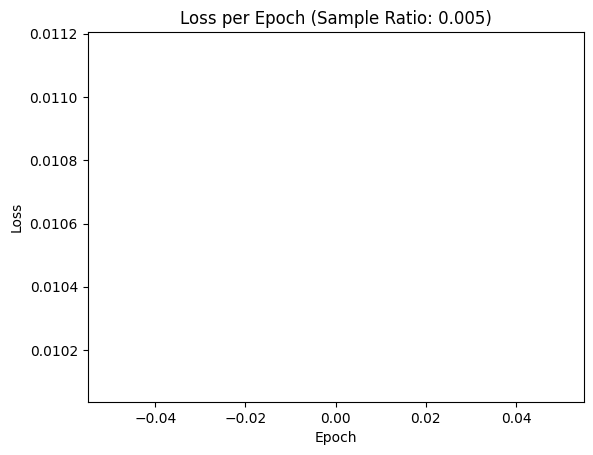

Metrics for 0.006 sampling ratio:
Validation Metrics:
Confusion Matrix:
[[635426      3]
 [   396    437]]
F1-score: 0.6865671641791046
Precision: 0.9931818181818182
Recall: 0.524609843937575
Accuracy: 0.9993728998431464

Test Metrics:
Confusion Matrix:
[[635415      5]
 [   412    430]]
F1-score: 0.6734534064212999
Precision: 0.9885057471264368
Recall: 0.5106888361045131
Accuracy: 0.9993446096105064



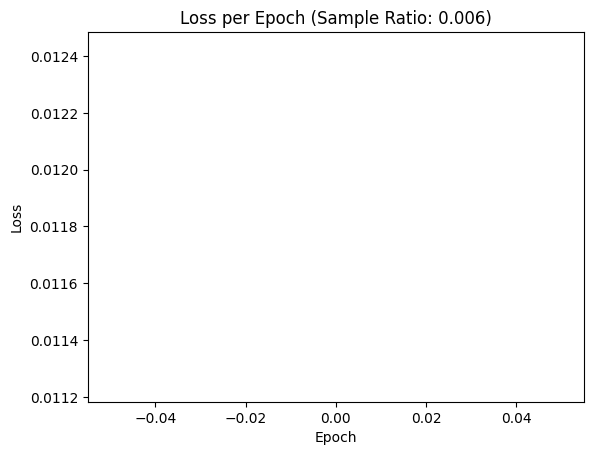

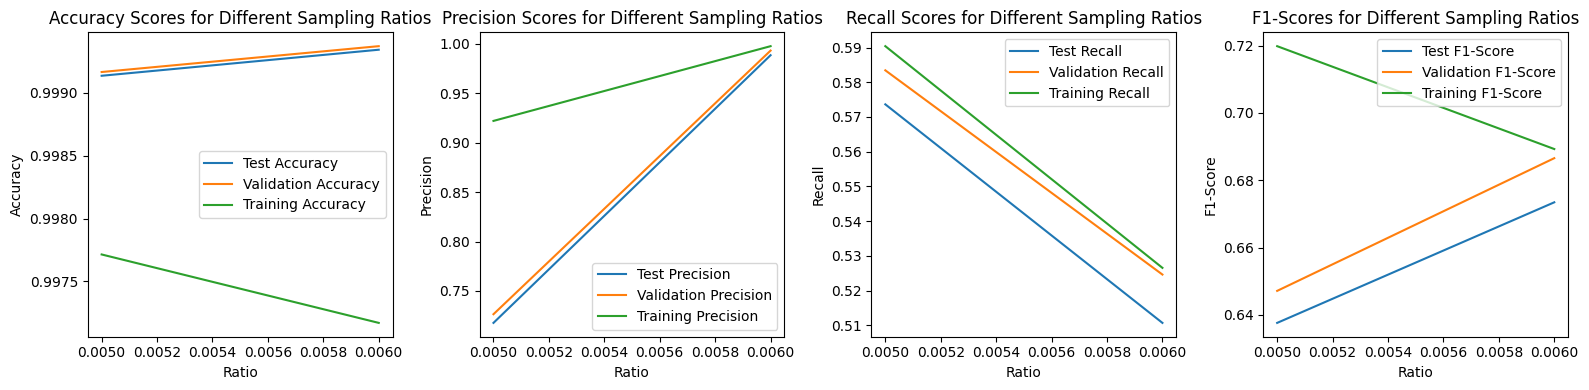

In [63]:
# Print the results
'''
for i, ratio in enumerate(sampling_ratios):
    print(f"Metrics for sampling ratio {ratio}:")
    print("Validation Metrics:")
    print("Confusion Matrix:")
    print(val_metrics[i][0])
    print("F1-score:", val_metrics[i][1])
    print("Precision:", val_metrics[i][2])
    print("Recall:", val_metrics[i][3])
    print("Accuracy:", val_metrics[i][4])

    print("Test Metrics:")
    print("Confusion Matrix:")
    print(test_metrics[i][0])
    print("F1-score:", test_metrics[i][1])
    print("Precision:", test_metrics[i][2])
    print("Recall:", test_metrics[i][3])
    print("Accuracy:", test_metrics[i][4])
    print()'''
    
# Print and plot the metrics
for i, ratio in enumerate(sampling_ratios):
    print(f"Metrics for {ratio} sampling ratio:")
    print("Validation Metrics:")
    val_cm, val_f1, val_precision, val_recall, val_accuracy = val_metrics[i]
    print("Confusion Matrix:")
    print(val_cm)
    print("F1-score:", val_f1)
    print("Precision:", val_precision)
    print("Recall:", val_recall)
    print("Accuracy:", val_accuracy)
    print()

    print("Test Metrics:")
    test_cm, test_f1, test_precision, test_recall, test_accuracy = test_metrics[i]
    print("Confusion Matrix:")
    print(test_cm)
    print("F1-score:", test_f1)
    print("Precision:", test_precision)
    print("Recall:", test_recall)
    print("Accuracy:", test_accuracy)
    print()
    
    plt.plot(range(0, epochs), loss_per_epoch[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per Epoch (Sample Ratio: {ratio})')
    plt.show()
    
    
# Create subplots with a row layout
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

# Plot accuracy scores

axs[0].plot(sampling_ratios, test_accuracy_scores, label='Test Accuracy')
axs[0].plot(sampling_ratios, validation_accuracy_scores, label='Validation Accuracy')
axs[0].plot(sampling_ratios, train_accuracy_scores, label='Training Accuracy')
axs[0].set_xlabel('Ratio')
axs[0].set_ylabel('Accuracy')
axs[0].set_title('Accuracy Scores for Different Sampling Ratios')
axs[0].legend()

# Plot precision scores

axs[1].plot(sampling_ratios, test_precision_scores, label='Test Precision')
axs[1].plot(sampling_ratios, validation_precision_scores, label='Validation Precision')
axs[1].plot(sampling_ratios, train_precision_scores, label='Training Precision')
axs[1].set_xlabel('Ratio')
axs[1].set_ylabel('Precision')
axs[1].set_title('Precision Scores for Different Sampling Ratios')
axs[1].legend()

# Plot recall scores

axs[2].plot(sampling_ratios, test_recall_scores, label='Test Recall')
axs[2].plot(sampling_ratios, validation_recall_scores, label='Validation Recall')
axs[2].plot(sampling_ratios, train_recall_scores, label='Training Recall')
axs[2].set_xlabel('Ratio')
axs[2].set_ylabel('Recall')
axs[2].set_title('Recall Scores for Different Sampling Ratios')
axs[2].legend()

# Plot F1 scores

axs[3].plot(sampling_ratios, test_f1_scores, label='Test F1-Score')
axs[3].plot(sampling_ratios, validation_f1_scores, label='Validation F1-Score')
axs[3].plot(sampling_ratios, train_f1_scores, label='Training F1-Score')
axs[3].set_xlabel('Ratio')
axs[3].set_ylabel('F1-Score')
axs[3].set_title('F1-Scores for Different Sampling Ratios')
axs[3].legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

#### Interpretation of the above data

It seems that the redistribution of data increases the recall value but also decreases the precision value. We think 0.1 is the best ratio to use for resampling the data because the recall rate was close to 80% on the test data but also had an 86% on the precision. 